In [18]:
import torch
import pickle
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt


from itertools import combinations
from tqdm import tqdm
from matplotlib.colors import LogNorm

In [5]:
base_dir = "/home/shpark/prj-mlcv/lib/bioemu/res/cln025-org/0727_0157"

# Load generated samples

In [9]:
sampled_res_file = "samples_sidechain_rec.xtc"
sampled_pdb_file = "samples_sidechain_rec.pdb"

traj = md.load(
    f"{base_dir}/{sampled_res_file}",
    top=f"{base_dir}/{sampled_pdb_file}",
)
print(traj.xyz.shape)

(9647, 92, 3)


In [13]:
ca_resid_pair = np.array(
    [(a.index, b.index) for a, b in combinations(list(traj.topology.residues), 2)]
)
all_traj_ca_pair_distances, _ = md.compute_contacts(
	traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
print(all_traj_ca_pair_distances.shape)

(9647, 45)


# TICA & Committor

In [15]:
tica_model_path = "/home/shpark/prj-mlcv/lib/DESRES/data/CLN025_tica_model_switch_lag5.pkl"
tica_model = pickle.load(open(tica_model_path, "rb"))
print(tica_model)

committor_path = "/home/shpark/prj-mlcv/lib/bioemu/notebook/committor.pt"
committor_model = torch.jit.load(committor_path)
print(committor_model)

TICA(commute_map=False, dim=2, epsilon=1e-06, kinetic_map=True, lag=5,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)
RecursiveScriptModule(
  original_name=NN_committor_guess
  (nn): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Tanh)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=Tanh)
    (4): RecursiveScriptModule(original_name=Linear)
    (5): RecursiveScriptModule(original_name=CustomActivation)
  )
)


In [16]:
def cad2switch(
    cad,
    cutoff: float = 0.8
) -> np.ndarray:
	if type(cad) == torch.Tensor:
		cad = cad.numpy()
	return (1 - np.power(cad / cutoff, 6)) / (1 - np.power(cad / cutoff, 12))

(5000, 2)


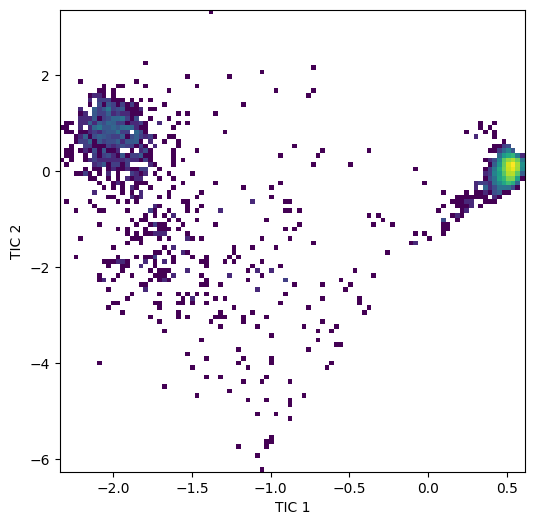

In [38]:
data_all_path = "/home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-5k/current-cad.pt"
data_all = torch.load(data_all_path).numpy()
data_all_switch = cad2switch(data_all)

tica_data = tica_model.transform(data_all_switch)
x = tica_data[:, 0]
y = tica_data[:, 1]
print(tica_data.shape)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hist2d(x, y, bins=100, norm=LogNorm())
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
plt.show()

(9647, 2)


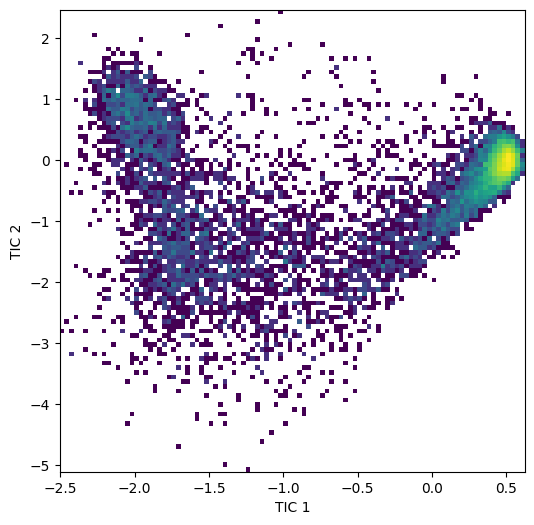

In [21]:
sampled_data_switch = cad2switch(all_traj_ca_pair_distances)
sampled_data_tica = tica_model.transform(sampled_data_switch)
print(sampled_data_tica.shape)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hist2d(sampled_data_tica[:, 0], sampled_data_tica[:, 1], bins=100, norm=LogNorm())
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
plt.show()

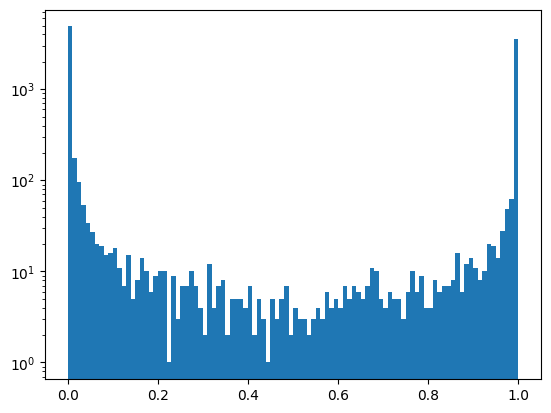

In [35]:
committor_model_val = committor_model(torch.from_numpy(all_traj_ca_pair_distances).to("cuda"))

# print(committor_model_val.shape)
plt.hist(
    committor_model_val.cpu().detach().numpy(),
    bins=100,
    log=True
)
plt.show()